In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange

from src.ksd.models import create_mixture_gaussian
from src.ksd.langevin import RandomWalkMH

# Metropolis-Adjusted Langevin dynamics

In [19]:
tf.random.set_seed(0)

In [20]:
delta = 4.
n = 500
dim = 5

target = create_mixture_gaussian(dim=dim, delta=delta)
one_component_mean = - delta * tf.eye(dim)[:, 0]

proposal_off = tfd.MultivariateNormalDiag(one_component_mean)
# proposal_off = tfd.MultivariateNormalDiag(0.*one_component_mean, 6*tf.ones(dim))
proposal_on = create_mixture_gaussian(dim=dim, delta=delta)

In [21]:
off_samples = proposal_off.sample(n)
on_samples = proposal_on.sample(n)

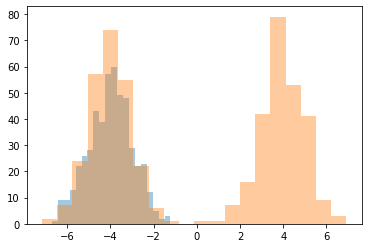

In [22]:
_ = plt.hist(off_samples.numpy()[:, 0], bins=20, label="off-target", alpha=0.4)
_ = plt.hist(on_samples.numpy()[:, 0], bins=20, label="target", alpha=0.4)

In [23]:
def log_prob_fn(x):
    exp1 = tf.reduce_sum((x - one_component_mean)**2, axis=-1) # n
    exp2 = tf.reduce_sum((x + one_component_mean)**2, axis=-1) # n
    return tf.math.log(
        tf.math.exp(- 0.5 * exp1) + tf.math.exp(- 0.5 * exp2)
    )

mh_off = RandomWalkMH(log_prob=log_prob_fn)

In [24]:
steps = 20
std = 5.
x_init_off = tf.identity(off_samples)

mh_off.run(steps=steps, std=std, x_init=x_init_off, verbose=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 146.41it/s]


In [25]:
# check if the hard-coded log_prob equals to the built-in fn
diff = log_prob_fn(x_init_off) - proposal_on.log_prob(x_init_off)
tf.experimental.numpy.allclose(diff, diff[0])

<tf.Tensor: shape=(), dtype=bool, numpy=True>

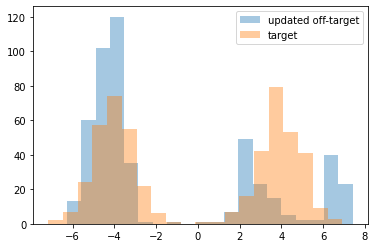

In [26]:
_ = plt.hist(mh_off.x.numpy()[-1, :, 0], bins=20, label="updated off-target", alpha=0.4)
_ = plt.hist(on_samples.numpy()[:, 0], bins=20, label="target", alpha=0.4)
_ = plt.legend()

In [27]:
def plot_steps(plot_t_step, result):
    nplots = steps // plot_t_step
    nrows = int(np.sqrt(nplots))
    ncols = int(np.ceil(nplots / nrows))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*nrows, 3*ncols))

    ind = 0
    t = 0
    for row in ax:
        for col in row:
            if ind >= nplots: break

            col.hist(result.x.numpy()[t, :, 0], bins=40, label="updated off-target", alpha=0.4)
            col.hist(on_samples.numpy()[:, 0], bins=20, label="target", alpha=0.4)
    #         res_df = pd.DataFrame({"x": result.x.numpy()[t, :, 0], "type": "updated off-target"})
    #         res_df2 = pd.DataFrame({"x": on_samples.numpy()[:, 0], "type": "target"})
    #         res_df = pd.concat([res_df, res_df2], ignore_index=True)
    #         sns.ecdfplot(ax=col, data=res_df, hue="type", x="x", alpha=0.4)
    #         col.legend()
            col.set_title(f"t = {t}")

            if t == 0:
                col.legend()

            ind += 1
            t += plot_t_step

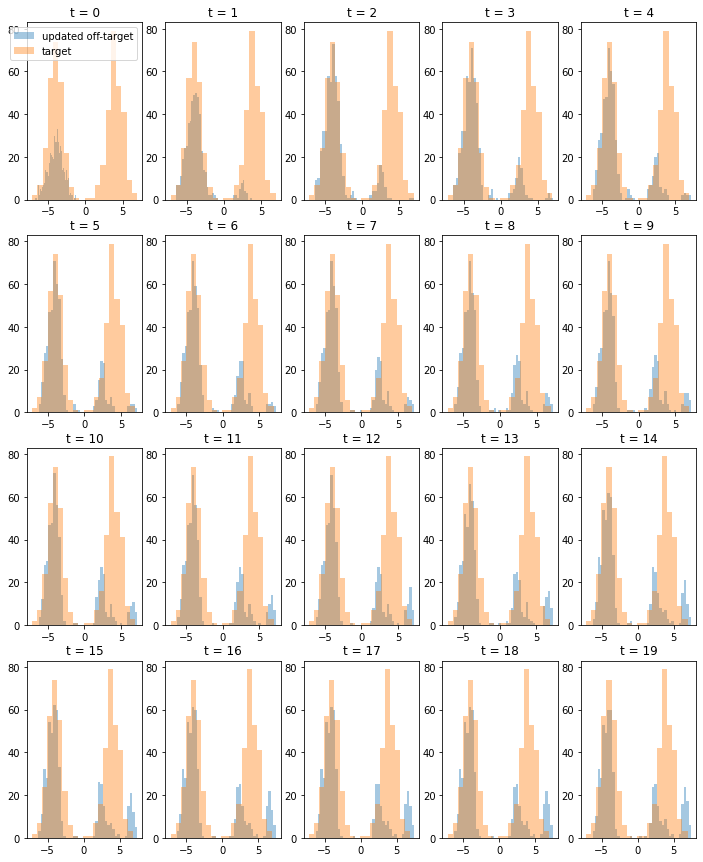

In [28]:
plot_t_step = 1 # plot every xxx steps
plot_steps(plot_t_step=plot_t_step, result=mh_off)

In [32]:
mh_on = RandomWalkMH(log_prob=proposal_on.log_prob)

x_init_on = tf.identity(on_samples)
mh_on.run(steps=steps, std=std, x_init=x_init_on)

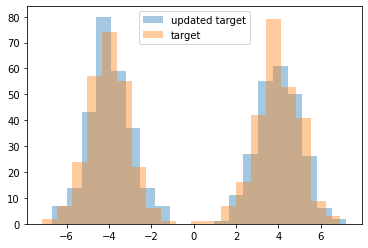

In [33]:
_ = plt.hist(mh_on.x.numpy()[-1, :, 0], bins=20, label="updated target", alpha=0.4)
_ = plt.hist(on_samples.numpy()[:, 0], bins=20, label="target", alpha=0.4)
_ = plt.legend()

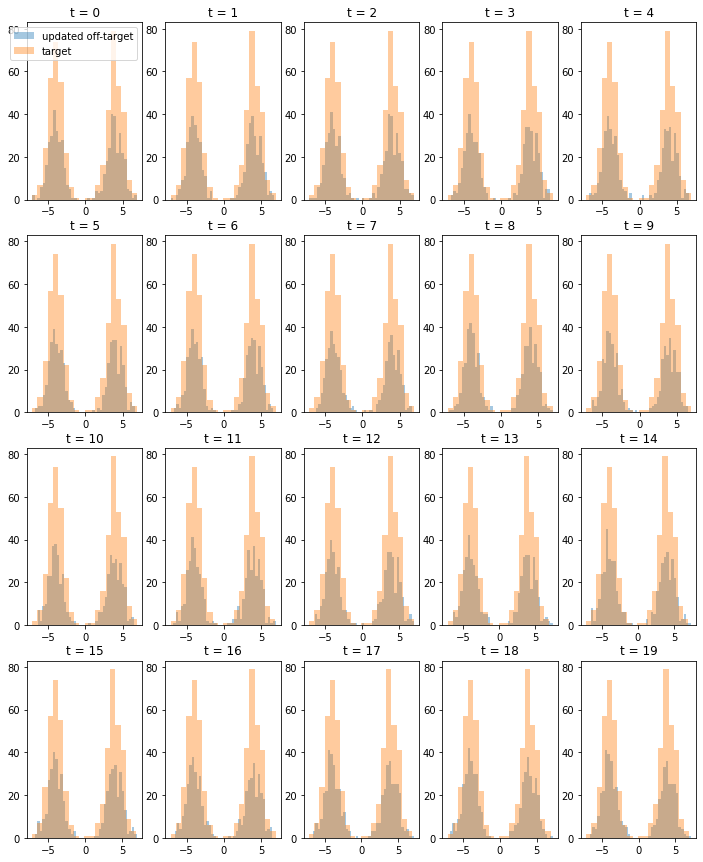

In [34]:
plot_steps(plot_t_step=plot_t_step, result=mh_on)

# KSD as a function of number of steps

In [12]:
from src.ksd.ksd import KSD
from src.ksd.kernel import RBF, IMQ

In [13]:
tf.random.set_seed(0)

In [14]:
kernel = IMQ(med_heuristic=True)

ksd = KSD(target=target, kernel=kernel)

nrep = 5

In [15]:
def run_mh_experiment(nrep, proposal_off, proposal_on, steps, std):
    ksd_df = pd.DataFrame(columns=["t", "ksd", "seed", "type"])

    iterator = trange(nrep)
    for seed in iterator:
        off_samples = proposal_off.sample(n)
        on_samples = proposal_on.sample(n)
        
        x_init_off = off_samples
        x_init_on = on_samples

        mh_off = RandomWalkMH(log_prob=log_prob_fn)
        mh_off.run(steps=steps, std=std, x_init=x_init_off)

        mh_on = RandomWalkMH(log_prob=log_prob_fn)
        mh_on.run(steps=steps, std=std, x_init=x_init_on)

        for t in range(steps):
            iterator.set_description(f"Time step {t+1} of {steps}")

            x_t = mh_off.x[t, :, :].numpy()
            ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
            ksd_df.loc[len(ksd_df)] = [t, ksd_val, seed, "off-target"]
            
            x_t = mh_on.x[t, :, :].numpy()
            ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
            ksd_df.loc[len(ksd_df)] = [t, ksd_val, seed, "target"]
            
    return ksd_df

In [16]:
nsteps = 20
std = 5.

ksd_df = run_mh_experiment(
    nrep=nrep, 
    proposal_off=proposal_off, 
    proposal_on=proposal_on, 
    steps=nsteps, 
    std=std)

  0%|          | 0/5 [00:00<?, ?it/s]

In [17]:
# # ksd_df = pd.read_csv("res/mh.csv")
# ksd_df.to_csv(f"res/mh_{std}.csv", index=False)

<AxesSubplot:xlabel='t', ylabel='ksd'>

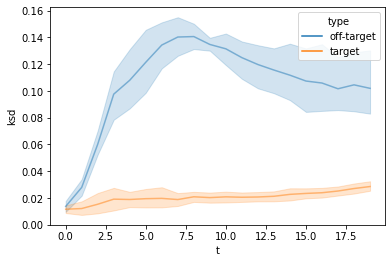

In [18]:
sns.lineplot(data=ksd_df, x="t", y="ksd", hue="type", alpha=0.5)

<AxesSubplot:xlabel='t', ylabel='ksd'>

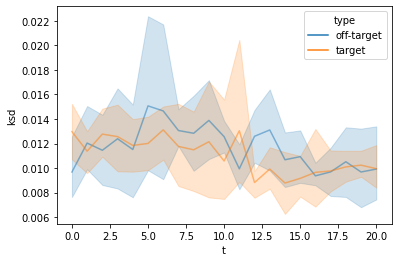

In [292]:
sns.lineplot(data=ksd_df.loc[ksd_df.t <= 20, ], x="t", y="ksd", hue="type", alpha=0.5)

# Check if the test controls p-value

In [ ]:
from src.ksd.ksd import KSD
from src.ksd.kernel import RBF, IMQ

In [ ]:
tf.random.set_seed(0)

In [ ]:
kernel = IMQ(med_heuristic=True)

ksd = KSD(target=target, kernel=kernel)

nrep = 10